# Setup

In [1]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import datetime

import pandas as pd
from pandas import DataFrame,Series,read_table

General info

In [2]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig 02/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = 'Fig2c_'

In [3]:
#path = '/Users/svcanavan/Dropbox/Coding in progress/00_BudgieSleep/Data_copies/'

birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['6 LEEGm-LEEGp', '5 LEEGf-LEEGp'], #, '9 REEGp-LEEGp'], # extra channel to represent R hemisphere
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'], #, '9 REEGf-REEGm'], # extra channel to represent R hemisphere
                     ['9REEGm-REEGp', '4LEEGf-LEEGp'], 
                     ['6LEEGm-LEEGf', '9REEGf-REEGp'], 
                     ['7REEGf-REEGp', '4LEEGf-LEEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'

## Path to detect SW ands EM events: use folder w/ EMs and EM artifacts detected during non-sleep
events_path = '../data_copies/SWs_EMs_and_EMartifacts/'

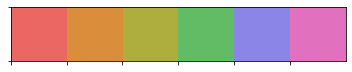

In [4]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

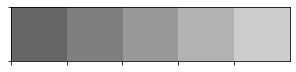

In [5]:
colors_birds = [np.repeat(.4, 3),
                np.repeat(.5, 3),
                np.repeat(.6, 3),
                np.repeat(.7, 3),
                np.repeat(.8, 3)]

sns.palplot(colors_birds)


Plot-specific info

In [6]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")
axis_label_fontsize = 24

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [7]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

## LEGEND: bird colors

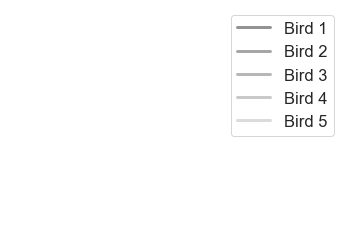

In [8]:
# Markers for bird colors
legendMarkers_birds = []
for b in range(nBirds):
    legendMarkers_birds.append(plt.Line2D([0],[0], color=colors_birds[b], linewidth=3, alpha=0.7))  
plt.legend(legendMarkers_birds, ['Bird 1', 'Bird 2', 'Bird 3', 'Bird 4', 'Bird 5'])
sns.despine(bottom=True, left=True)
plt.yticks([])
plt.xticks([])


if savePlots:
        plt.savefig(saveAsPath + saveAsName + "bird_color_legend.pdf")

## Read in files

### Load formatted scores

In [9]:
AllScores = {}
for b in range(nBirds):
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores[bird_name] = data

## Calculate lights off in Zeitgeber time (s and hrs)
Lights on is 0 

In [10]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

## Set bin size as 1/2 of the night

In [11]:
nightLength_hr = np.mean(0 - lightsOffZeit_hr)

binSize_min = 60 * nightLength_hr/2

## Make table of % of each stage per bin

In [12]:
binSize_s = int(binSize_min*60)
binSize_ep = int(binSize_s/epochLength)

stageProportions_whole_night_all = {}

for b in range(nBirds):
    nBins = int(np.ceil(np.min(lightsOnSec - lightsOffSec)/(60*binSize_min)))

    stageProportions = DataFrame([], columns=range(len(stages)))

    b_name = 'Bird ' + str(b+1)
    Scores = AllScores[b_name]

    for bn in range(nBins):

        start_ep = int(lightsOffEp[b] + bn*binSize_ep)
        end_ep   = int(lightsOffEp[b] + (bn+1)*binSize_ep)

        bn_scores = Scores[start_ep:end_ep]
        bn_stage_frequencies = bn_scores['Label (#)'].value_counts(normalize=True,sort=False)
                
        stageProportions = stageProportions.append(bn_stage_frequencies, ignore_index=True)
    
    # Replace NaNs with 0
    stageProportions = stageProportions.fillna(0)
    
    # Calc TST and sleep stages as % TST
    
    stageProportions['TST'] = stageProportions[[2,3,4,5]].sum(axis=1)

    stageProportions['U (% TST)'] = stageProportions[2]/stageProportions['TST']
    stageProportions['I (% TST)'] = stageProportions[3]/stageProportions['TST']
    stageProportions['S (% TST)'] = stageProportions[4]/stageProportions['TST']
    stageProportions['R (% TST)'] = stageProportions[5]/stageProportions['TST']

    # Add to dictionary
    stageProportions_whole_night_all[b] = stageProportions
    

### Plot by half of night: all stages

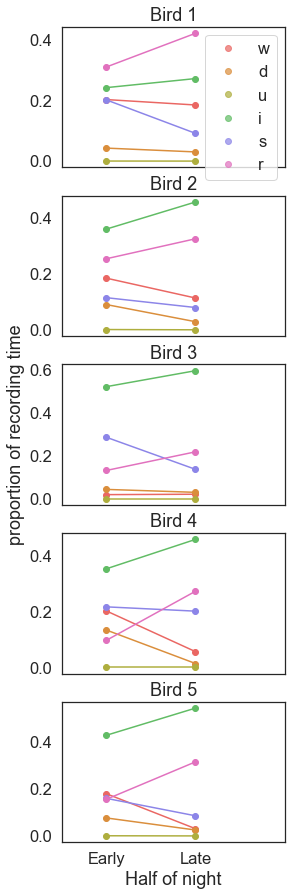

In [13]:
plt.figure(figsize=(4,3*nBirds))

for b in range(nBirds):
    stageProportions = stageProportions_whole_night_all[b]
    
    # Plot
    with sns.color_palette(colors):
        plt.subplot(nBirds,1,b+1)
        plt.plot(stageProportions[[0,1,2,3,4,5]], 'o-')
        
    # Labels etc
    plt.title('Bird ' + str(b+1))
    plt.xlim((-0.5, len(stageProportions)))
    if b == 2:
        plt.ylabel('proportion of recording time')
        
    # Legend just on first graph
    if b == 0:
        plt.legend(legendMarkersEEG, stages, loc=1)
        
    # X-axis labels just on last graph
    if b < nBirds-1:
        plt.xticks([])
    else:
        plt.xticks([0,1], ['Early', 'Late'])
        plt.xlabel('Half of night')
        
#if savePlots:
#    plt.savefig(saveAsPath  + saveAsName + "_All_birds_by_half_of_night.pdf")

### By hour of night: sleep only

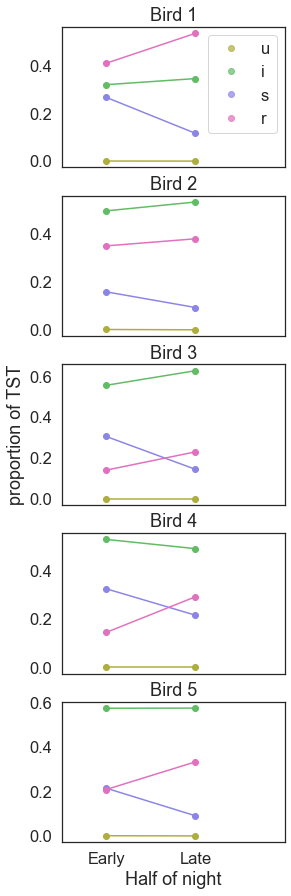

In [14]:
plt.figure(figsize=(4,3*nBirds))

for b in range(nBirds):

    stageProportions = stageProportions_whole_night_all[b]

    # Plot
    with sns.color_palette(colors[2:6]):
        plt.subplot(nBirds,1,b+1)
        plt.plot(stageProportions[['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']], 'o-')
    
    # Labels etc
    plt.title('Bird ' + str(b+1))
    plt.xlim((-0.5, len(stageProportions)))
    if b == 2:
        plt.ylabel('proportion of TST')
    # Legend just on first graph

    if b == 0:
        plt.legend(legendMarkersEEG[2:6], stages[2:6], loc=1)
        
    # X-axis labels just on last graph
    if b < nBirds-1:
        plt.xticks([])
    else:
        plt.xticks([0,1], ['Early', 'Late'])
        plt.xlabel('Half of night')
        
#if savePlots:
#    plt.savefig(saveAsPath + saveAsName  + "_All_birds_by_percent_of_TST.pdf")

### By hour of sleep

In [15]:
stageProportions_sleep_only = {}

for b in range(nBirds):
    b_name = 'Bird ' + str(b+1)
    Scores = AllScores[b_name]

    Scores_Nighttime = Scores[int(lightsOffEp[b]):int(lightsOnEp[b])]

    Scores_Nighttime_Sleep = Scores_Nighttime[Scores_Nighttime['Label (#)']>=2]

    # Re-index to consecutive numbers starting at 0
    Scores_Nighttime_Sleep = Scores_Nighttime_Sleep.reset_index(drop=True)
    
    # Determine bin size (1/2 of nighttime TST)
    
    TST_night_ep = len(Scores_Nighttime_Sleep)
    binSize_TST_ep = TST_night_ep/2

    nBins_sleep = int(np.ceil(len(Scores_Nighttime_Sleep)/(binSize_TST_ep)))

    stageProportions = DataFrame([], columns=np.arange(2,6))

    for bn in range(nBins_sleep):

        start_ep = int(bn*binSize_TST_ep)
        end_ep   = int((bn+1)*binSize_TST_ep)

        bn_scores = Scores_Nighttime_Sleep[start_ep:end_ep]
        bn_stage_frequencies = bn_scores['Label (#)'].value_counts(normalize=True,sort=False)

        stageProportions = stageProportions.append(bn_stage_frequencies, ignore_index=True)

    # Replace NaNs with 0
    stageProportions = stageProportions.fillna(0)
    
    # Add to dictionary
    stageProportions_sleep_only[b] = stageProportions

Plot

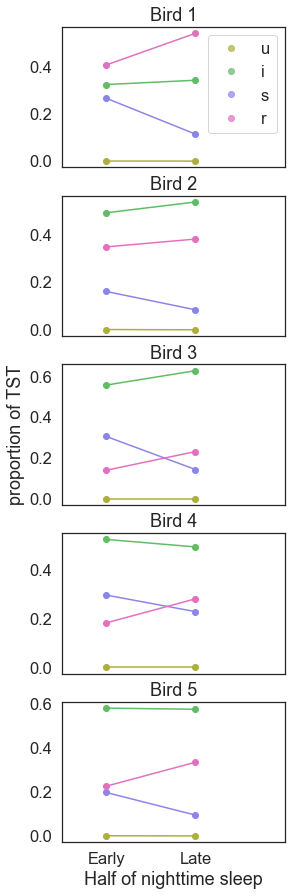

In [16]:
plt.figure(figsize=(4,3*nBirds))

for b in range(nBirds):
    stageProportions = stageProportions_sleep_only[b]
    
    # Plot
    with sns.color_palette(colors[2:6]):
        plt.subplot(nBirds,1,b+1)
        plt.plot(stageProportions[[2,3,4,5]], 'o-')
    
    # Labels etc
    plt.title('Bird ' + str(b+1))
    plt.xlim((-0.5, len(stageProportions)))
    if b == 2:
        plt.ylabel('proportion of TST')
    # Legend just on first graph

    if b == 0:
        plt.legend(legendMarkersEEG[2:6], stages[2:6], loc=1)
        
    # X-axis labels just on last graph
    if b < nBirds-1:
        plt.xticks([])
    else:
        plt.xticks([0,1], ['Early', 'Late'])
        plt.xlabel('Half of nighttime sleep')
        
#if savePlots:
#    plt.savefig(saveAsPath + saveAsName  + "_All_birds_by_half_of_nighttime_sleep.pdf")

# Organize proportions by stage (instead of by bird)

In [17]:
stageProportions_by_stage = {}

stage_labels_by_bin = stageProportions_whole_night_all[0].columns.values

for st in stage_labels_by_bin:
    stageProportions_stage = DataFrame([])
    
    for b in range(nBirds):
        stageProportions_bird = stageProportions_whole_night_all[b]
        stageProportions_stage['Bird ' + str(b+1)] = stageProportions_bird[st]
        
    stageProportions_by_stage[st] = stageProportions_stage

In [18]:
stage_labels_by_sleep = stageProportions_sleep_only[0].columns.values

for st in stage_labels_by_sleep:
    stageProportions_stage = DataFrame([])
    
    for b in range(nBirds):
        stageProportions_bird = stageProportions_sleep_only[b]
        stageProportions_stage['Bird ' + str(b+1)] = stageProportions_bird[st]
        
    stageProportions_by_stage[str(st) + ' by half of sleep'] = stageProportions_stage

Find means and SDs over time

In [19]:
Means = DataFrame([])
SDs = DataFrame([])

for st in stage_labels_by_bin:
    tmp_mean = stageProportions_by_stage[st].mean(axis=1)
    tmp_sd = stageProportions_by_stage[st].std(axis=1)
    
    Means[st] = tmp_mean
    SDs[st] = tmp_sd
    
for st in stage_labels_by_sleep:
    tmp_mean = stageProportions_by_stage[str(st) + ' by half of sleep'].mean(axis=1,skipna=True)
    tmp_sd = stageProportions_by_stage[str(st) + ' by half of sleep'].std(axis=1,skipna=True)
    
    Means[str(st) + ' by half of sleep'] = tmp_mean
    SDs[str(st) + ' by half of sleep'] = tmp_sd

## Save to csv

In [20]:
if saveData:
    for key in stageProportions_by_stage.keys():
        stageProportions = stageProportions_by_stage[key]
        stageProportions.to_csv(saveAsPath + saveAsName + str(key) + '.csv')

# FIGURE 2C: Bar graphs: Plot each stage

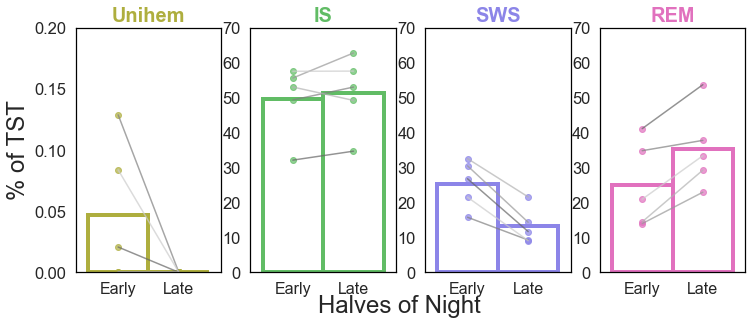

In [21]:
stage_names = ['Unihem','IS','SWS','REM']

axis_color = [.8,.8,.8]
with plt.rc_context({'axes.edgecolor': 'k'}):  # set color of plot outline

    plt.figure(figsize=(12,4.5))

    column=1
    for st in ['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']:
        stage_color = colors[2:6][column-1]
        plt.subplot(1,4,column)

        # Scatter plot of each bird
        plt.plot(stageProportions_by_stage[st]*100, 'o', color=colors[2:6][column-1], alpha=.7)
        
        # Lines color coded by bird
        for b in range(nBirds):
            b_name = 'Bird ' + str(b+1)
            plt.plot(stageProportions_by_stage[st][b_name]*100, color=colors_birds[b], alpha=.7)

        # Bar graph of mean
        plt.bar([0,1],Means[st]*100, width=1, color='none', edgecolor=stage_color, linewidth=4)


        plt.xlim(-.7, 1.7)
        plt.xticks([0,1], ['Early', 'Late'],fontsize=16)
        plt.title(stage_names[column-1], color=stage_color, fontsize=20, fontweight='bold')

        if column==1:
            plt.ylabel('% of TST', fontsize=axis_label_fontsize)  # y label only on leftmost plot
            plt.ylim(0,.2)          # smaller y scale for unihem sleep
        elif column==2:
            plt.ylim(0,70)
        else:
            plt.ylim(0,70)

        column=column+1

    fig = plt.gcf()
    fig.text(0.5, 0, 'Halves of Night', ha='center', fontsize=axis_label_fontsize)

if savePlots:
        plt.savefig(saveAsPath + saveAsName + "summary_barplot.pdf")

In [22]:
stageProportions_by_stage['I (% TST)']

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
0,0.321008,0.493242,0.555979,0.530239,0.575199
1,0.346635,0.530053,0.627621,0.491883,0.575743


In [23]:
stageProportions_by_stage['S (% TST)']

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
0,0.267713,0.157477,0.304694,0.325363,0.214914
1,0.116538,0.092428,0.143185,0.215732,0.090594


In [24]:
stageProportions_by_stage['R (% TST)']

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
0,0.411072,0.347994,0.139327,0.144398,0.209049
1,0.536827,0.377520,0.229194,0.292385,0.333663


## FIGURE 2C STATS: t-tests

### IS

In [25]:
data = stageProportions_by_stage['I (% TST)']
data

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
0,0.321008,0.493242,0.555979,0.530239,0.575199
1,0.346635,0.530053,0.627621,0.491883,0.575743


In [26]:
data.mean(axis=1)

0    0.495133
1    0.514387
dtype: float64

In [27]:
data.std(axis=1)

0    0.102064
1    0.106629
dtype: float64

In [28]:
stat.ttest_rel(data.loc[0], data.loc[1])

Ttest_relResult(statistic=-1.047062403995699, pvalue=0.35416822038292706)

### SWS

In [29]:
data = stageProportions_by_stage['S (% TST)']
data

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
0,0.267713,0.157477,0.304694,0.325363,0.214914
1,0.116538,0.092428,0.143185,0.215732,0.090594


In [30]:
data.mean(axis=1)

0    0.254032
1    0.131695
dtype: float64

In [31]:
data.std(axis=1)

0    0.068365
1    0.051612
dtype: float64

In [32]:
stat.ttest_rel(data.loc[0], data.loc[1])

Ttest_relResult(statistic=7.175592360263929, pvalue=0.0019974760987470047)

### REM

In [33]:
data = stageProportions_by_stage['R (% TST)']
data

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
0,0.411072,0.347994,0.139327,0.144398,0.209049
1,0.536827,0.377520,0.229194,0.292385,0.333663


In [34]:
data.mean(axis=1)

0    0.250368
1    0.353918
dtype: float64

In [35]:
data.std(axis=1)

0    0.123110
1    0.115937
dtype: float64

In [36]:
stat.ttest_rel(data.loc[0], data.loc[1])

Ttest_relResult(statistic=-4.9999358700982155, pvalue=0.007490773732489366)